In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from MIDI import *
from models import *

ModuleNotFoundError: No module named 'mido'

In [7]:
arrdict_bars = np.load('/content/drive/My Drive/ML/magenta-dataset/magenta_full_23_12_64bpb_bars.npz', allow_pickle = True)
arrdict_tracks = np.load('/content/drive/My Drive/ML/magenta-dataset/magenta_full_23_12_64bpb_tracks.npz', allow_pickle = True)

#print(sorted([k for k in arrdict_tracks.keys()]))
nd = arrdict_bars['notedict'].item()
bars = arrdict_bars['bars']
print(nd)

{22: 0, 26: 1, 36: 2, 37: 3, 38: 4, 40: 5, 42: 6, 43: 7, 44: 8, 45: 9, 46: 10, 47: 11, 48: 12, 49: 13, 50: 14, 51: 15, 52: 16, 53: 17, 55: 18, 57: 19, 58: 20, 59: 21}


In [69]:
vae = VAE(16, bars.shape[-2:], debug = False)
hist = vae.train(bars, 250, batch_size = 512, validation_split=.1)

Train on 19525 samples, validate on 2170 samples
Epoch 1/250
19525/19525 [==============================] - 2s 123us/sample - loss: 7.1535 - recon_loss: 7.1577 - val_loss: 9.9273 - val_recon_loss: 9.8711
Epoch 2/250
19525/19525 [==============================] - 1s 45us/sample - loss: 7.0374 - recon_loss: 7.0257 - val_loss: 9.8826 - val_recon_loss: 9.8314
Epoch 3/250
19525/19525 [==============================] - 1s 45us/sample - loss: 7.0184 - recon_loss: 7.0162 - val_loss: 9.8604 - val_recon_loss: 9.8083
Epoch 4/250
19525/19525 [==============================] - 1s 46us/sample - loss: 7.0033 - recon_loss: 7.0004 - val_loss: 9.8143 - val_recon_loss: 9.7572
Epoch 5/250
19525/19525 [==============================] - 1s 45us/sample - loss: 6.9861 - recon_loss: 6.9812 - val_loss: 9.7375 - val_recon_loss: 9.6326
Epoch 6/250
19525/19525 [==============================] - 1s 46us/sample - loss: 6.9506 - recon_loss: 6.9088 - val_loss: 9.6698 - val_recon_loss: 9.5362
Epoch 7/250
19525/19525 [=

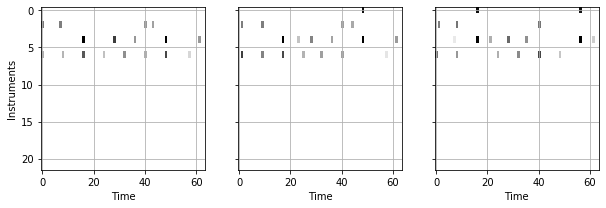

In [53]:
song = arrdict_tracks['drum grooves_magenta_drummer8_eval_session_1_funk-groove1_138_beat_4-4.mid']

fig, axes = plt.subplots(1,3,sharey = True, figsize = (10,3))
for i in range(3):
    axes[i].grid()
    axes[i].set_xlabel('Time')
    axes[0].set_ylabel('Instruments')
    axes[i].imshow(1 - song[i].T, aspect = 'auto')
fig.savefig(outputdir + 'arrayrep.pdf', bbox_inches = 'tight')

In [99]:
vae = VAE(16, bars.shape[-2:], debug = False, weights='/content/weights/2020-01-06_18:03:16')

[20340 14018 21663 21669]
0.0 1.0
0.0 1.0620202
(4, 64, 22)
(4, 64, 22)


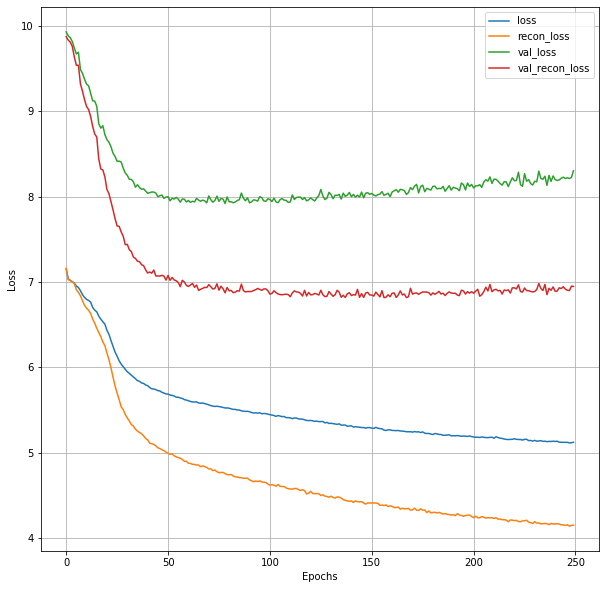

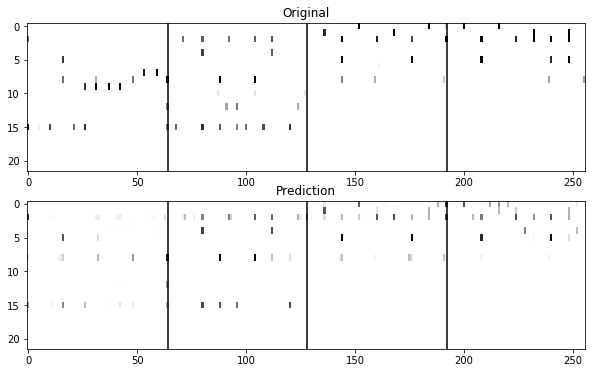

In [93]:
song = arrdict_tracks['drum grooves_magenta_drummer8_session2_9_hiphop_86_beat_4-4.mid']
#inds = np.random.randint(0, bars.shape[0], 4)
song = bars[inds]
print(inds)
song_pred = vae.VAE.predict(song)
song_pred.shape

for s,n in zip([song, song_pred], ['_orig', '_pred']):
  print(np.min(s), np.max(s))
  s = np.clip(s, 0, 1)
  writeBarArray(s, outputdir + 'groove' + n, nd)

plt.figure(figsize = (10,10))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
for k in hist.history.keys():
    plt.plot(hist.history[k], '-', label = k)
plt.legend()
plt.savefig(outputdir + '16d.pdf', bbox_inches = 'tight')

fig, axes = plt.subplots(2,1, figsize = (10,6))
axes[0].set_title('Original')
axes[1].set_title('Prediction')
plt.gray()

for i, s in enumerate([song, song_pred]):
  print(s.shape)
  axes[i].imshow(1 - np.concatenate(s).T, aspect = 'auto', vmin = 0, vmax = 1)
  j = s.shape[1]
  while j < np.prod(s.shape[:2]):
    axes[i].axvline(j, c = 'k')
    j += s.shape[1]
fig.savefig(outputdir + 'rand_pred.pdf', bbox_inches = 'tight')

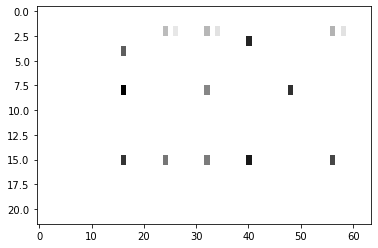

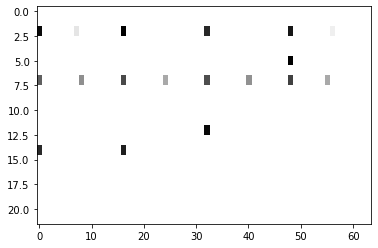

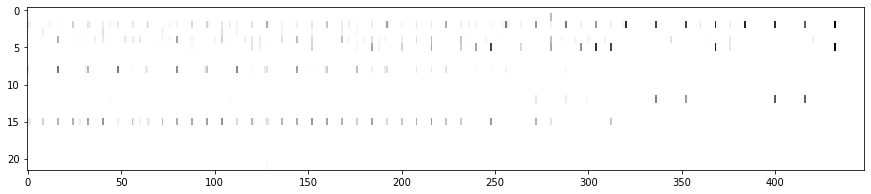

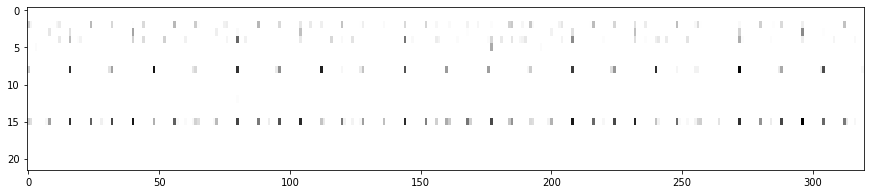

In [102]:
# Interpolation

bar1 = bars[1631]
bar2 = bars[10027]
n_steps = 7

for i,b in enumerate([bar1, bar2]):
  plt.figure()
  plt.imshow(1 - b.T, aspect = 'auto')
  writeBarArray(np.array([b]*n_steps), f'{outputdir}bar{i+1}', nd)


bars_pred = vae.interpolate(bar1, bar2, n_steps)
writeBarArray(bars_pred, outputdir + 'bars_interpolated', nd)

plt.figure(figsize=(15,3))
plt.imshow(1 - np.concatenate(bars_pred).T, aspect = 'auto')

# sampling

bars_sampled = vae.sample(bar1, 5)
plt.figure(figsize=(15,3))
plt.imshow(1 - np.concatenate(bars_sampled).T, aspect = 'auto')

In [101]:
bars_sampled.shape

(5, 64, 22)

In [0]:
hidden_dims = np.arange(10,50,3)
#hidden_dims = np.arange(1,3)
hidden_dims = np.sort(np.random.randint(1, 256, 32))
n_epochs = 250
print(hidden_dims)

scores = {
    'loss':[],
    'val_loss':[],
    'recon_loss':[],
    'val_recon_loss':[]
}

for i,d in enumerate(hidden_dims):
  print(f'Training with {d}-dimensional latent space, {i + 1}/{hidden_dims.shape[0]}')
  tf.keras.backend.clear_session()
  vae = VAE(int(d), bars.shape[-2:], debug=False)
  hist = vae.train(bars, n_epochs, batch_size = 1024, validation_split=0.1, verbose = 0)
  for k in hist.history.keys():
    if k in scores.keys(): scores[k].append(hist.history[k])

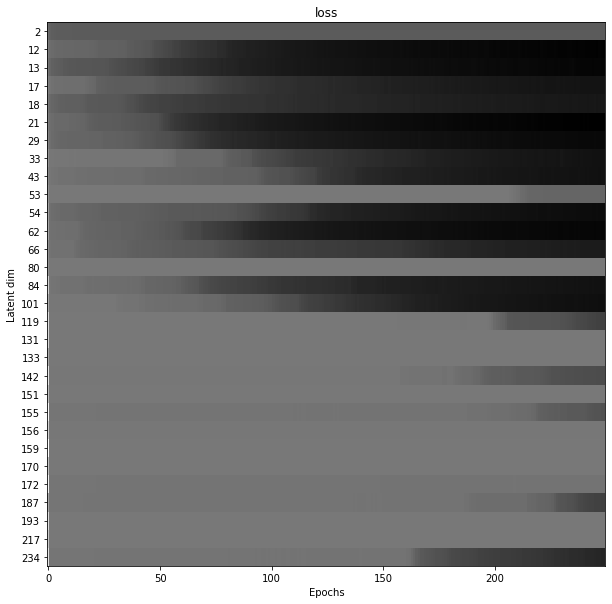

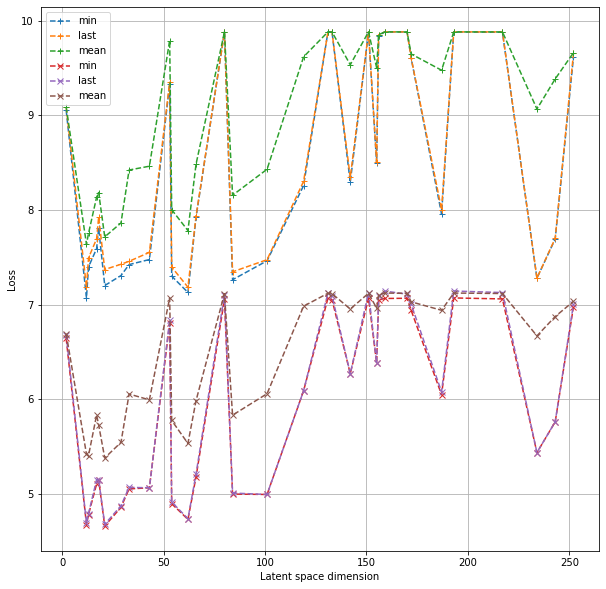

In [78]:
for k in ['loss']:
    plt.figure(figsize = (10, 10))
    plt.title(k)
    plt.imshow(np.array(scores[k])[:-2,:], aspect = 'auto')
    plt.xlabel('Epochs')
    plt.ylabel('Latent dim')
    plt.yticks(ticks = np.arange(hidden_dims.shape[0] - 2), labels = list(hidden_dims[:-2]))

vrl = np.array(scores['val_recon_loss'])
rl = np.array(scores['recon_loss'])
plt.figure(figsize = (10, 10))
plt.xlabel('Latent space dimension')
plt.ylabel('Loss')
plt.grid()
for loss, style in zip([vrl, rl], ['+--', 'x--'], ):
    plt.plot(hidden_dims, np.min(loss, axis = 1), style, label = 'min')
    plt.plot(hidden_dims, loss[:,-1], style, label = 'last')
    plt.plot(hidden_dims, np.mean(loss, axis = 1), style, label = 'mean')
plt.legend()
plt.savefig(outputdir + 'latent_dim.pdf', bbox_inches = 'tight')